### Baseline models and Feature Selection

In [45]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score

from constants import DATA_DIR
from utils import csv_concatenate, calculate_FPTS, calculate_MAE, calculate_RMSE, cross_val

In [100]:
np.random.seed(0)
warnings.filterwarnings("ignore")

### Simple Season Average
Baseline model - DraftKings shows season average in their data and interface

In [101]:
df_baseline = csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Baseline'))
df_baseline.sort_values(by=['Date','Name']).reset_index(drop=True, inplace=True)
df_baseline['FPTS_pred'] = calculate_FPTS(df_baseline)

# Season average
print(' MAE | ', calculate_MAE(df_baseline['FPTS_pred'], df_baseline['FPTS']))
print('RMSE | ', calculate_RMSE(df_baseline['FPTS_pred'], df_baseline['FPTS']))


 MAE |  7.472289544657329
RMSE |  9.921164051956424


In [102]:
# Linear Regression with basic 9 variables counted for fantasy points
df_baseline = df_baseline
basic =  ['PTS','3P','AST','TRB','STL','BLK','TOV', 'DD', 'TD']

X = df_baseline.loc[:, basic]
X = MinMaxScaler().fit_transform(X)
y = df_baseline['FPTS'].values.reshape(-1,1).flatten()

reg = LinearRegression()
cross_val(reg, X, y, nfolds=5, verbose=1)


[Training Eror]
 MAE | Mean: 7.56774, SD: 0.00784
RMSE | Mean: 9.86556, SD: 0.01144

[Validation Error]
 MAE | Mean: 7.57319, SD: 0.03217
RMSE | Mean: 9.85258, SD: 0.04571


### Weighted Features
Choose weighting scheme from linear, square root and quadratic

In [103]:
features = ['SG', 'F', 'C', 'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT',
            'FTA', 'FGA', '3PA', 'DRB', 'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc',
            'ORB_perc', 'BLK_perc', 'TOV_perc', 'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']

In [104]:
for weighting in ['sqrt', 'linear', 'quad']:
    print("\nweighting sheme:", weighting)
    df_features = csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))  
    
    X = df_features.loc[:, features]
    X = MinMaxScaler().fit_transform(X)
    y = df_features['FPTS'].values.reshape(-1,1).flatten()

    reg = LinearRegression()
    cross_val(reg, X, y, nfolds=5, verbose=0)


weighting sheme: sqrt



[Validation Error]
 MAE | Mean: 7.33355, SD: 0.04243
RMSE | Mean: 9.61004, SD: 0.06262

weighting sheme: linear



[Validation Error]
 MAE | Mean: 7.30567, SD: 0.04419
RMSE | Mean: 9.58473, SD: 0.06456

weighting sheme: quad



[Validation Error]
 MAE | Mean: 7.30426, SD: 0.04765
RMSE | Mean: 9.59096, SD: 0.06601


### Feature Selection with Feature Importances

In [124]:
weighting = 'linear'
df_features = csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))  

In [120]:
_all = ['Salary', 'Rest', 'Rota_All', 'Rota_Pos', 'Home', 'SG', 'F', 'C', 'Value', 'FPTS_std',
        'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT', 'FTA', 'FGA', '3PA', 'DRB',
        'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc', 'ORB_perc', 'BLK_perc', 'TOV_perc', 
        'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']

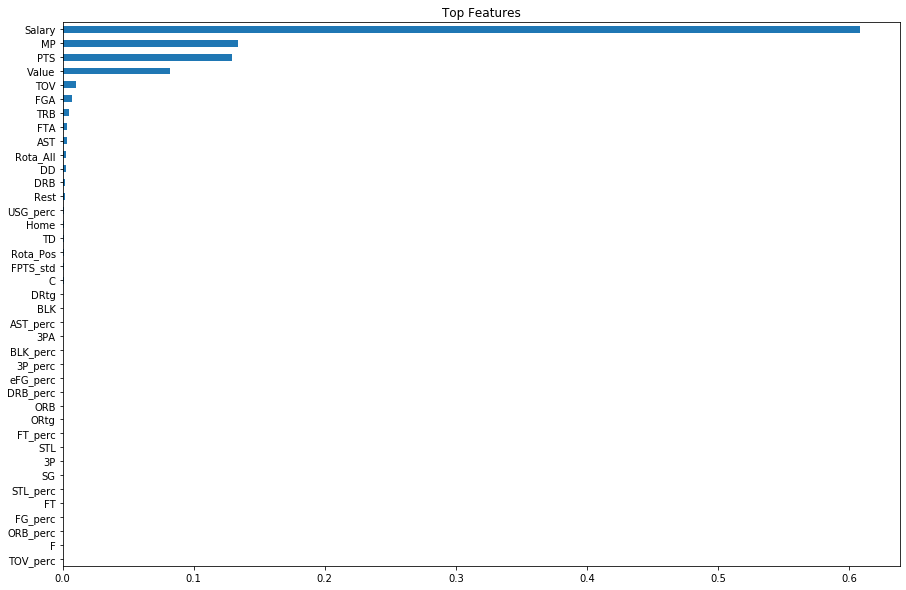

In [121]:
X = df_features.loc[:, _all]
X = MinMaxScaler().fit_transform(X)
y = df_features['FPTS'].values.reshape(-1,1).flatten()

# Takes 2 minutes
model = GradientBoostingRegressor()
model.fit(X, y)

top_features = pd.Series(model.feature_importances_, index = _all).sort_values()
top_features.plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()

### Linear Regression with All / Selected Features

In [128]:
omit_lowest = 10
_selected = list(top_features[omit_lowest:].index)

In [129]:
for weighting in ['sqrt', 'linear', 'quad']:
    print("\nweighting sheme:", weighting)
    df_features = csv_concatenate(os.path.join(DATA_DIR, 'Dataframes','Modelling', 'Features', weighting))
    
    for feature_type in [_all, _selected]:
        X = df_features.loc[:, feature_type]
        X = MinMaxScaler().fit_transform(X)
        y = df_features['FPTS'].values.reshape(-1,1).flatten()

        reg = LinearRegression()

        reg.fit(X, y)
        cross_val(reg, X, y, verbose=0)


weighting sheme: sqrt



[Validation Error]
 MAE | Mean: 7.28797, SD: 0.04126
RMSE | Mean: 9.54591, SD: 0.05979



[Validation Error]
 MAE | Mean: 7.29712, SD: 0.0405
RMSE | Mean: 9.55567, SD: 0.0598

weighting sheme: linear



[Validation Error]
 MAE | Mean: 7.25764, SD: 0.04189
RMSE | Mean: 9.51487, SD: 0.06149



[Validation Error]
 MAE | Mean: 7.26727, SD: 0.04137
RMSE | Mean: 9.5256, SD: 0.06177

weighting sheme: quad



[Validation Error]
 MAE | Mean: 7.2352, SD: 0.04257
RMSE | Mean: 9.49186, SD: 0.06223



[Validation Error]
 MAE | Mean: 7.24544, SD: 0.04222
RMSE | Mean: 9.50363, SD: 0.06278


### Season Average Baseline
- MAE - 7.47229
- RMSE - 9.92116

### Linear Regression with Additional Features and Quadratic Weighting
- MAE - Mean: 7.24544, SD: 0.04222
- RMSE - Mean: 9.50363, SD: 0.06278
